In [1]:
%load_ext autoreload
%autoreload 2

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from utils import ImageDataset
from network import SimpleCNN

from IPython.display import display

import numpy as np
from PIL import Image

# Load Model

In [2]:
model_path = './models/simpleCNN_L3.249_07-12-2021_19-41-06.pth'

model = SimpleCNN()
model.load_state_dict(torch.load(model_path))
model.eval()

SimpleCNN(
  (layer1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 3, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (sigmoid): Sigmoid()
)

# Load Data

In [3]:
input_transform = transforms.ToTensor()

pred_trans = transforms.ToPILImage(mode='L')

feature_trans = transforms.ToPILImage(mode='RGB')

testset = ImageDataset('./data/DJI_0013', transform=input_transform, target_transform=input_transform)
testloader = DataLoader(testset, batch_size=1, shuffle=False)

dataiter = iter(testloader)

Feature:


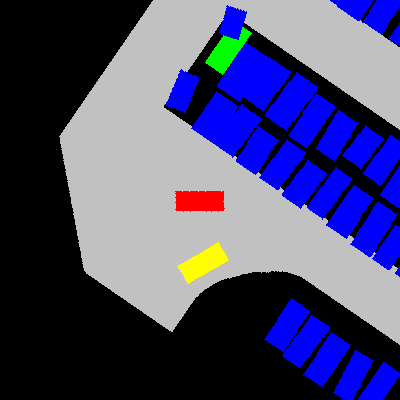

Label:


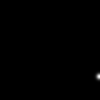

Pred


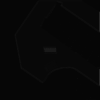

In [32]:
inputs, labels = dataiter.next()

preds = model(inputs)

# Transform back to image

pred_heatmap = pred_trans(preds[0, 0])
feature_image = feature_trans(inputs[0])
label_heatmap = Image.fromarray(np.floor(labels[0, 0].numpy() * 255).astype('uint8'))

# Display
print("Feature:")
display(feature_image)

print("Label:")
display(label_heatmap)

print("Pred")
display(pred_heatmap)